# Non-parametric Data Synthesis

In [18]:
import glob
import numpy as np
from PIL import Image

# Get a list of all image file paths in the "Texture Patches" folder
image_paths = glob.glob("Texture Patches/*.png")

print("Image : (Height, Width, Channels)")
print("-------------------------------")
# Iterate over the image file paths
for image_path in image_paths:
    # Open the image using PIL
    image = Image.open(image_path)
    
    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Print the shape of the image array
    print(image_path.split("\\")[-1].split(".")[0] + " : " + str(image_array.shape))

Image : (Height, Width, Channels)
-------------------------------
1 : (530, 530, 4)
10 : (530, 530, 4)
11 : (530, 530, 4)
12 : (529, 530, 4)
2 : (529, 531, 4)
3 : (530, 530, 4)
4 : (530, 529, 4)
5 : (530, 529, 4)
6 : (531, 530, 4)
7 : (531, 529, 4)
8 : (530, 530, 4)
9 : (530, 531, 4)


Texture Patches\7.png


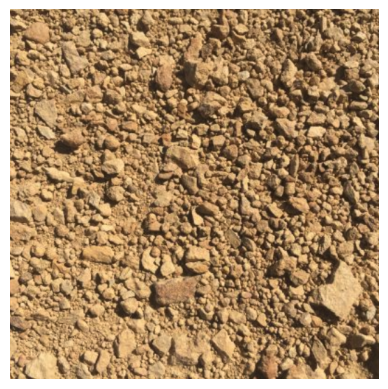

In [19]:
SYNTH_SIZE = (530, 530)#(1000,1200)    # (height, width)  # (1000,1200) ran for 300 minutes and didn't reach 10% completion
KERNEL_SIZE = 15             # Kernel size for the texturing window

image_path = image_paths[-3]
print(image_path)
image_array = np.array(Image.open(image_path))
#image_array[0:3,:,:] = [255,0,0,255] # [R,G,B,A]   # Red line at top

import matplotlib.pyplot as plt

# Display the image
plt.imshow(image_array) # White boarder is not there
plt.axis('off')
plt.show()


In [20]:
print(image_array[0,0,:])

[228 203 148 255]


In [21]:
# Get patches for the image
def get_patches(image_array, kernel_size, stride:int=1):
    patches = []
    for i in range(0, image_array.shape[0]-kernel_size, stride):
        for j in range(0, image_array.shape[1]-kernel_size, stride):
            patch = image_array[i:i+kernel_size, j:j+kernel_size, :] / 255.0
            patches.append(patch)
    return np.array(patches)

patches = get_patches(image_array, KERNEL_SIZE)

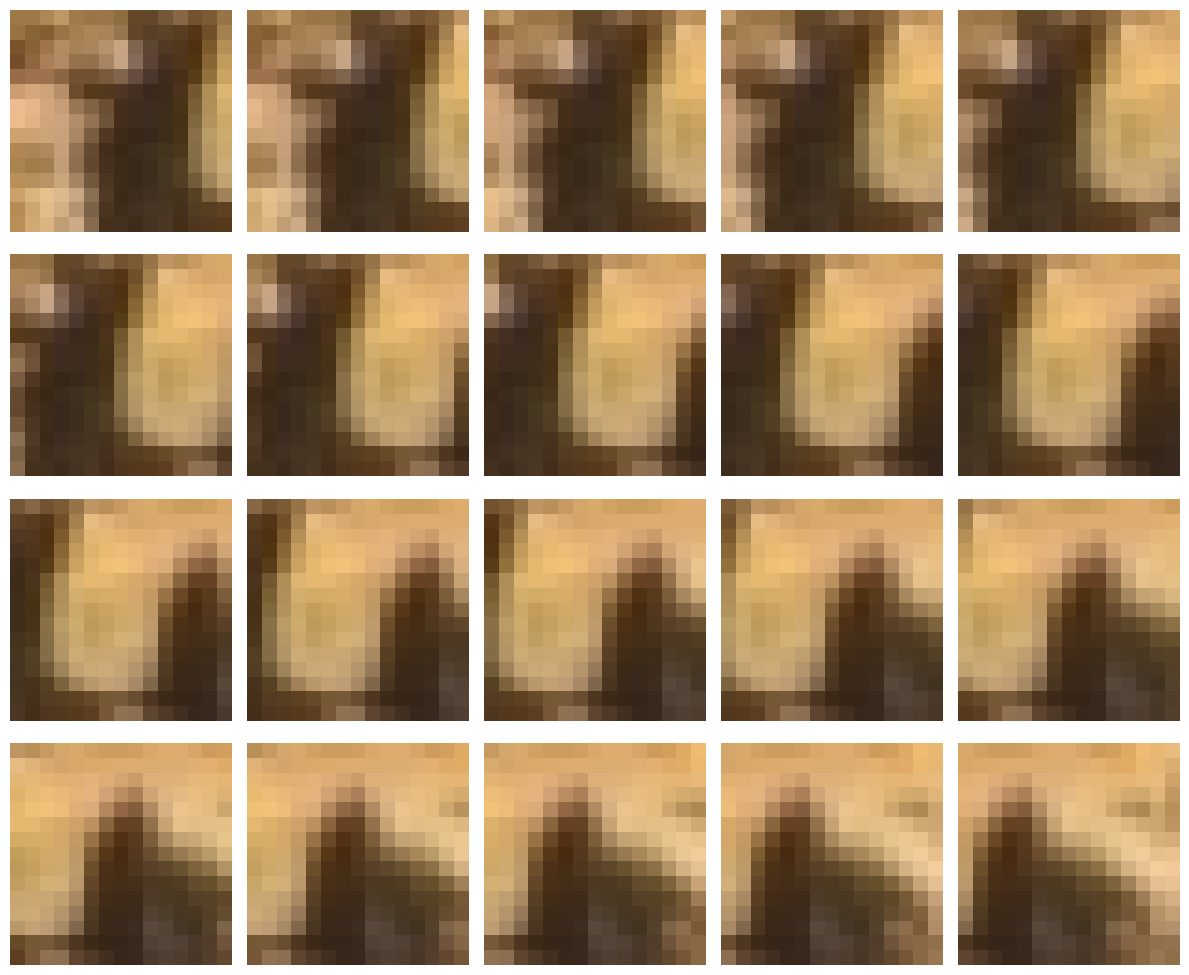

In [22]:
import random

# Create a grid of subplots
fig, axs = plt.subplots(4, 5, figsize=(12, 10))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Generate a random index for selecting patches
random_index = random.randint(0, len(patches) - 1)

# Iterate over the subplots and plot the randomly selected patches
for i, ax in enumerate(axs):
    # Get the patch at the random index
    patch = patches[random_index]
    
    # Plot the patch in the corresponding subplot
    ax.imshow(patch)
    ax.axis('off')
    
    # Increment the random index
    random_index += 1
    if random_index >= len(patches):
        random_index = 0

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [23]:
shape = patches.shape
# flat_patches = patches.reshape(shape[0],-1) # (1225, 900)
flat_patches = patches.reshape(shape[0],-1, shape[3]) # (1225, 225, 4)
print(shape)
print(flat_patches.shape)

(265224, 15, 15, 4)
(265224, 225, 4)


In [24]:
print(np.max(flat_patches), np.min(flat_patches))
print(np.max(patches), np.min(patches))

1.0 0.0
1.0 0.0


In [25]:
def create_gaussian_kernel(kernel_size, sigma=None):
    if sigma is None:
        sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8   # Scaling sigma based on kernel size, may need to adjust the coefficients
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(kernel_size-1)/2)**2 + (y-(kernel_size-1)/2)**2)/(2*sigma**2)), (kernel_size, kernel_size))
    return kernel / np.sum(kernel)

gaussian_kernel = create_gaussian_kernel(KERNEL_SIZE, 3)

In [33]:
def initialize_synthesized_image(example_img, synth_size):
    PATCH_SIZE = 3
    diff = PATCH_SIZE // 2

    # Create a blank image to store the synthesized image
    synthesized_img = np.zeros(synth_size + (example_img.shape[-1],))
    potential_map = np.zeros(synth_size, dtype=int)
    #visited_map = np.zeros(synth_size, dtype=bool)

    # Randomly select a 3x3 patch to add to the center of the synthesized image
    center_i = (synthesized_img.shape[0] // 2)
    center_j = (synthesized_img.shape[1] // 2)
    row = random.randint(0, example_img.shape[0] - PATCH_SIZE)
    col = random.randint(0, example_img.shape[1] - PATCH_SIZE)
    synthesized_img[center_i-diff:center_i+diff+1, center_j-diff:center_j+diff+1] = example_img[row:row+PATCH_SIZE, col:col+PATCH_SIZE,:]/255.0
    #visited_map[center_i-diff:center_i+diff+1, center_j-diff:center_j+diff+1] = True

    # Update the potential map as distance from the center patch
    for i in range(synthesized_img.shape[0]):
        for j in range(synthesized_img.shape[1]):
            c_i, c_j = center_i, center_j
            if i <= center_i - diff:
                c_i = center_i - diff
            elif i >= center_i + diff:
                c_i = center_i + diff
            else:
                c_i = i

            if j <= center_j - diff:
                c_j = center_j - diff
            elif j >= center_j + diff:
                c_j = center_j + diff
            else:
                c_j = j

            potential_map[i,j] = (i - c_i)**2 + (j - c_j)**2

    potential_map = np.max(potential_map) - potential_map + 1
    potential_map[center_i-diff:center_i+diff+1, center_j-diff:center_j+diff+1] = 0

    return synthesized_img, potential_map #visited_map

synthesized_img, potential_map = initialize_synthesized_image(image_array, SYNTH_SIZE)

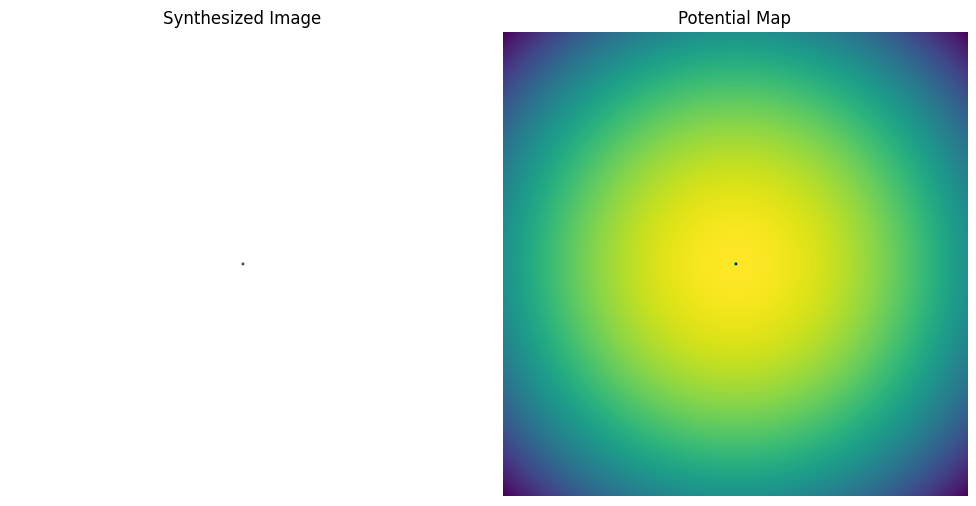

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot synthesized_img
axs[0].set_facecolor('black')
axs[0].imshow(synthesized_img)
axs[0].axis('off')
axs[0].set_title('Synthesized Image')

# Plot potential_map
axs[1].imshow(potential_map)
axs[1].axis('off')
axs[1].set_title('Potential Map')

plt.tight_layout()
plt.show()


In [28]:
x,y = int(potential_map.shape[0]/2), int(potential_map.shape[1]/2)
center_values = potential_map[x-3:x+4, y-3:y+4]
print(center_values)


[[139385 139388 139389 139389 139389 139388 139385]
 [139388 139391 139392 139392 139392 139391 139388]
 [139389 139392      0      0      0 139392 139389]
 [139389 139392      0      0      0 139392 139389]
 [139389 139392      0      0      0 139392 139389]
 [139388 139391 139392 139392 139392 139391 139388]
 [139385 139388 139389 139389 139389 139388 139385]]


In [14]:
n_no_pixels = np.where(potential_map != 0)[0].shape[0]
print(n_no_pixels)
print(potential_map.shape)

280891
(530, 530)


Parameters to change:
* Starting patch size
* Kernel Size
* sigma for gaussian

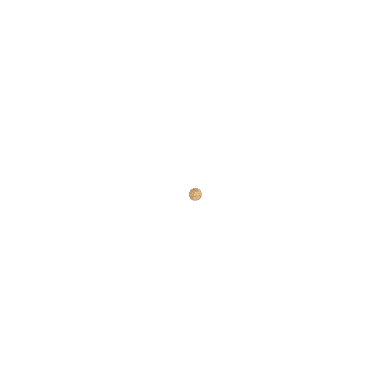

None

Processing pixel 231 of 280891


KeyboardInterrupt: 

In [60]:
from IPython.display import clear_output

def get_target_patch(synthesized_img, potential_map, i, j, kernel_size, diff):
    # Create a zero matrix to store the target patch
    target_patch = np.zeros((kernel_size, kernel_size, synthesized_img.shape[-1]))
    patch_mask = np.zeros((kernel_size, kernel_size))

    start_i, start_j = max(i-diff, 0), max(j-diff, 0)
    end_i, end_j = min(i+diff+1, synthesized_img.shape[0]), min(j+diff+1, synthesized_img.shape[1])

    # Copy the patch from the synthesized image to the target patch
    target_patch[start_i-i+diff:end_i-i+diff, start_j-j+diff:end_j-j+diff] = synthesized_img[start_i:end_i, start_j:end_j]

    # Create mask for known pixels
    patch_mask[start_i-i+diff:end_i-i+diff, start_j-j+diff:end_j-j+diff] = potential_map[start_i:end_i, start_j:end_j]
    patch_mask = (patch_mask == 0)

    return target_patch, np.repeat(patch_mask[:,:,np.newaxis], synthesized_img.shape[-1], axis=2)
        

def find_best_matching_patch(example_patches, target_patch, patch_mask, gaussian_kernel, theshold = 0.8, attenuation_factor=80):
    # Calculate the squared difference between the target patch and all example patches
    patches = np.copy(example_patches)
    patches -= target_patch # In place operations is faster than a single line operation
    patches *= patch_mask
    patches **= 2
    patches *= gaussian_kernel
    squared_diffs = np.sum(patches, axis=(1, 2, 3))

    # Convert the squared differences to probabilities
    prob = 1 - squared_diffs / np.max(squared_diffs)
    prob *= (prob > theshold*np.max(prob))  # thresholding the probabilities
    prob = prob**attenuation_factor  # attenuate the probabilities
    prob /= np.sum(prob)  # normalize the probabilities
    
    # Find the index of the best matching patch
    best_matching_patch_index = np.random.choice(np.arange(example_patches.shape[0]), p=prob)
    
    return example_patches[best_matching_patch_index]

def synthesize_texture(example_img, synth_size, kernel_size, sigma=3):
    # Initialize the synthesized image and potential map
    synthesized_img, potential_map = initialize_synthesized_image(example_img, synth_size)  # get started with a random patch and potential map
    
    # Get patches for the example image
    example_patches = get_patches(example_img, kernel_size) # get all the patches from the example image
    diff = kernel_size // 2

    # Create a Gaussian kernel 
    gaussian_kernel = np.repeat(create_gaussian_kernel(kernel_size, sigma)[:,:,np.newaxis], example_img.shape[-1], axis=2)  # create a Gaussian kernel

    # Get the number of non-zero pixels in the potential map
    n_no_pixels = np.where(potential_map != 0)[0].shape[0]
    
    # Iterate over the pixels in the synthesized image
    perc = 0 #0.1
    print(f"Processing pixel 0 of {n_no_pixels}")
    for n_pixel in range(n_no_pixels):
        if n_pixel / n_no_pixels > perc:
            #print(f"Processing pixel {n_pixel} of {n_no_pixels}")
            plt.imshow(synthesized_img)
            plt.axis('off')
            clear_output(wait=True)
            display(plt.show())
            print(f"Processing pixel {n_pixel} of {n_no_pixels}")
            # perc += 0.1

        # Find the pixel coordinates with the highest potential
        i, j = np.unravel_index(np.argmax(potential_map), potential_map.shape)  # get the pixel with the highest potential
        
        # Get the target patch from the synthesized image
        target_patch, patch_mask = get_target_patch(synthesized_img, potential_map, i, j, kernel_size, diff)  # get the target patch
        # target_patch = synthesized_img[i-diff:i+diff+1, j-diff:j+diff+1, :]
        
        # Find the best matching patch from the example image
        best_matching_patch = find_best_matching_patch(example_patches, target_patch, patch_mask, gaussian_kernel)    # BROKEN, NEEDS TO BE FIXED
                
        # Replace the pixel with the center pixel of the best matching patch
        synthesized_img[i, j] = np.copy(best_matching_patch[diff, diff])
        
        # Update the potential map
        potential_map[i, j] = 0
        
    return synthesized_img

synthesized_texture_img = synthesize_texture(image_array, SYNTH_SIZE, KERNEL_SIZE)

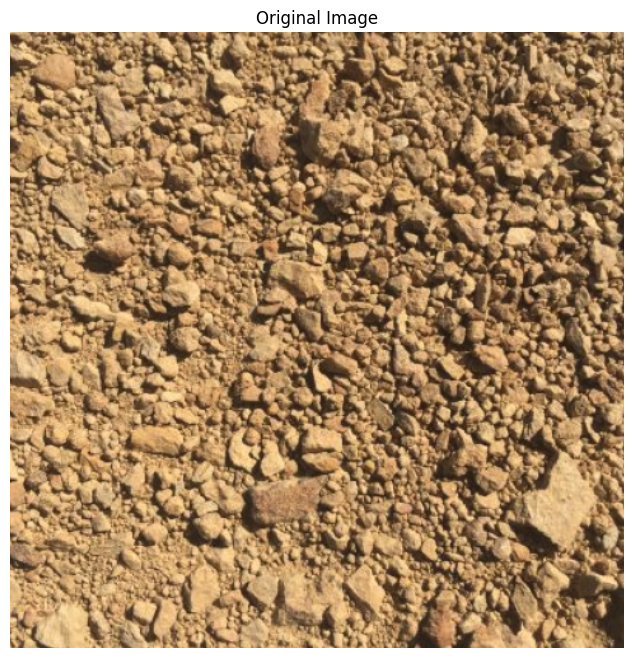

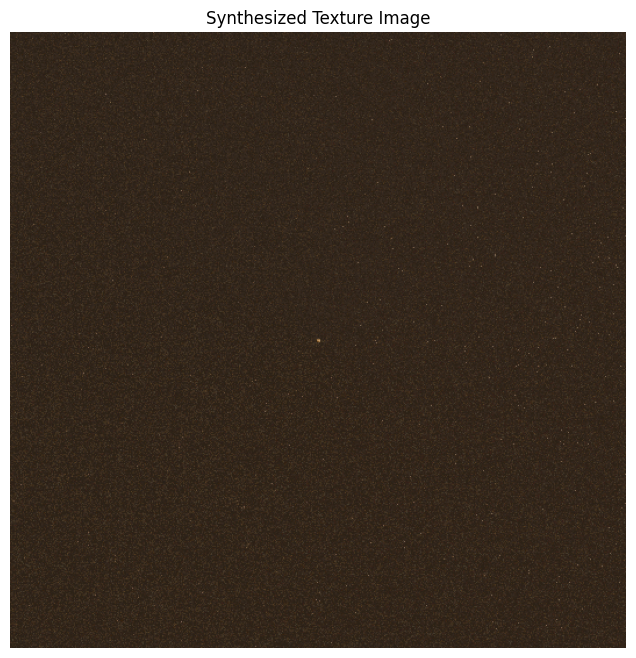

In [203]:
import matplotlib.pyplot as plt

# Plot image_array
plt.figure(figsize=(8, 8))
plt.imshow(image_array)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Plot synthesized_texture_img
plt.figure(figsize=(8, 8))
plt.imshow(synthesized_texture_img)
plt.title('Synthesized Texture Image')
plt.axis('off')
plt.show()
